# CAN Workshop- LFADS demo in pytorch

## Import necessary modules

In [1]:
%matplotlib inline

import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

import os
import yaml
import math
from lfads_k09 import LFADS_Net
from utils import read_data, load_parameters, save_parameters
import scipy.io
# plt.style.use('dark_background')
import shutil
path = './models_k09'
if os.path.isdir(path): 
    shutil.rmtree(path)

In [2]:
# Select device to train LFADS on
device = 'cuda' if torch.cuda.is_available() else 'cpu'; print('Using device: %s'%device)

Using device: cpu


## Load or Generate Data 

In [3]:
"""all_time =28000
start_time = 25000
Time = 500
neuron_num = 83
datax = scipy.io.loadmat("spike83_k09_35000.mat")
y_data = datax["spike83_k09_35000"][:,start_time:all_time].T
traj = scipy.io.loadmat("trj83_k09_35000.mat")
traj = traj["trj83_k09_35000"][:,start_time:all_time].T"""
all_time =14000
start_time = 10000
Time = 60
good_neuron_id = [0,1,2,3,6,7,8,11,12,13,15,17,18,21,22,23,24,25,27,29,31,32,33,36,37,39,40,44,45,49,50,51,53,54,55,60,61,62,63,66,67,68,69,70,71,72,73,74,75]

neuron_num = len(good_neuron_id)#76
datax = scipy.io.loadmat("spike76_k09_17000.mat")
y_data0 = datax["spike76_k09_17000"][:,start_time:all_time].T
traj = scipy.io.loadmat("trj76_k09_17000.mat")
traj = traj["trj76_k09_17000"][:,start_time:all_time].T
NRep=int((all_time-start_time)/Time)
output = np.zeros((NRep,Time,neuron_num))
y_data = np.zeros((all_time-start_time,neuron_num))
for i in range(neuron_num):
    y_data[:,i] = y_data0[:,good_neuron_id[i]]
print(y_data.shape)
for i in range(all_time-start_time):
    for j in range(neuron_num):
        if y_data[i][j] > 30:
            y_data[i][j] = 30
for i in range(NRep):
    output[i,:,:] = y_data[Time*i:Time*(i+1),:]
output = output.astype('float32')
output = torch.Tensor(output).to(device)
print(output.shape)
output_valid = output.detach().clone()

(4000, 49)
torch.Size([66, 60, 49])


## View example Ground Truth Firing Rates

(60, 49)


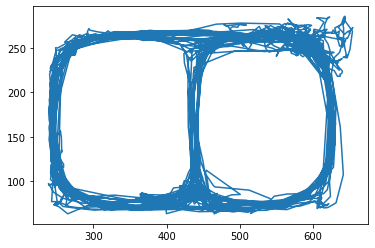

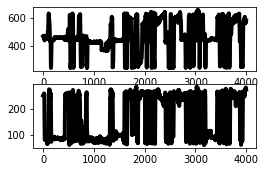

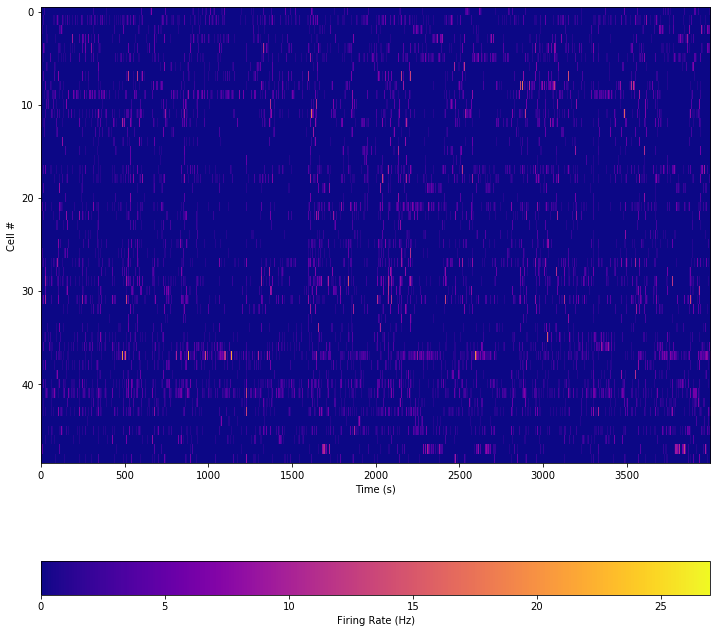

In [4]:
train_ds      = torch.utils.data.TensorDataset(output)
valid_ds      = torch.utils.data.TensorDataset(output)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(traj[:,0],traj[:,1])
plt.figure(figsize=(4, 4))
ax1 = plt.subplot(311)
ax1.plot(traj[:, 0], lw=4, color='k')

ax2 = plt.subplot(312, sharex=ax1)
ax2.plot(traj[:, 1], lw=4, color='k')    

# Z score output:
output=output.reshape(Time*NRep,neuron_num)
from scipy import stats
output = stats.zscore(output,axis=0)
output = output.reshape(NRep,Time,neuron_num)
print(output[0].shape)
plt.figure(figsize = (12,12))
plt.imshow(y_data.T, cmap=plt.cm.plasma,aspect='auto')
plt.xlabel('Time (s)')
plt.ylabel('Cell #')
plt.colorbar(orientation='horizontal', label='Firing Rate (Hz)')

In [5]:
#for i in range(neuron_num):
    #fig, ax = plt.subplots()
    #mappable = ax.scatter(traj[:,0], traj[:,1], c=y_data[:,i] ,cmap='coolwarm',vmin=0,vmax=10,s=3)
    #fig.colorbar(mappable)
    #plt.title(i)
    #plt.show()
#fig.savefig("img.png")

## LFADS Schema
<img src='lfads_schema.png' width=800 align=left>

## Load model hyperparameters 

In [6]:
hyperparams = load_parameters('./parameters_k09.yaml')
save_parameters(hyperparams)
hyperparams

C:\Users\flab\prog\lfads_torch_k09\utils.py:91: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  return yaml.load(open(path))


{'dataset_name': 'chaotic_rnn',
 'run_name': 'demo',
 'g_dim': 50,
 'u_dim': 50,
 'factors_dim': 2,
 'g0_encoder_dim': 50,
 'c_encoder_dim': 50,
 'controller_dim': 50,
 'g0_prior_kappa': 0.1,
 'u_prior_kappa': 0.1,
 'keep_prob': 0.95,
 'clip_val': 5.0,
 'max_norm': 200,
 'learning_rate': 0.012,
 'learning_rate_min': 1e-05,
 'learning_rate_decay': 0.9,
 'scheduler_on': True,
 'scheduler_patience': 6,
 'scheduler_cooldown': 6,
 'kl_weight_schedule_start': 0,
 'kl_weight_schedule_dur': 2000,
 'l2_weight_schedule_start': 0,
 'l2_weight_schedule_dur': 2000,
 'epsilon': 0.1,
 'betas': (0.9, 0.99),
 'l2_gen_scale': 2000,
 'l2_con_scale': 0}

## Instantiate LFADS model

In [7]:
model = LFADS_Net(inputs_dim = neuron_num, T = Time, dt = 1, device=device,
                 model_hyperparams=hyperparams).to(device)

Random seed: 226


#### Pick up where you left off (if you have a recent save) 

In [8]:
# model.load_checkpoint('recent')
batch_size = 10
"""tt = np.empty((3000,2))
for k in range(10):
    t = model.infer_trj(output_valid[batch_size *k:batch_size *(k+1),:])
    #print(t[90].shape)
    for i in range(batch_size):
        for j in range(100):
            tt[k*100*i+j,:]=t[j][i].to('cpu').detach().numpy().copy()
plt.figure()
plt.plot(tt)"""

"tt = np.empty((3000,2))\nfor k in range(10):\n    t = model.infer_trj(output_valid[batch_size *k:batch_size *(k+1),:])\n    #print(t[90].shape)\n    for i in range(batch_size):\n        for j in range(100):\n            tt[k*100*i+j,:]=t[j][i].to('cpu').detach().numpy().copy()\nplt.figure()\nplt.plot(tt)"

## Fit model

Rule of thumb: You can usually see good fit after 200 epochs (~30 mins runtime on Thinkpad GPU, ~2.5 hours on CPU), but to see good inference of perturbation timings need to run for about 800 epochs (~2 hours on Thinkpad GPU).

Beginning training...
Epoch:    1, Step:     7, training loss: 3372.074
recon: 2527, kl:     0, dir:    0, smo:    0, klf:    0, klw: 0.003500
Epoch:    2, Step:    14, training loss: 3020.381
recon: 2811, kl:     1, dir:    0, smo:    0, klf:    0, klw: 0.007000
Epoch:    3, Step:    21, training loss: 2983.516
recon: 3041, kl:     2, dir:    0, smo:    0, klf:    0, klw: 0.010500
Epoch:    4, Step:    28, training loss: 2980.712
recon: 3320, kl:     2, dir:    0, smo:    0, klf:    0, klw: 0.014000
Epoch:    5, Step:    35, training loss: 2895.204
recon: 2727, kl:     2, dir:    0, smo:    0, klf:    0, klw: 0.017500
Epoch:    6, Step:    42, training loss: 2786.461
recon: 2983, kl:     2, dir:    0, smo:    0, klf:    0, klw: 0.021000
Epoch:    7, Step:    49, training loss: 2692.818
recon: 2411, kl:     2, dir:    0, smo:    0, klf:    0, klw: 0.024500
Epoch:    8, Step:    56, training loss: 2688.643
recon: 2897, kl:     2, dir:    0, smo:    0, klf:    0, klw: 0.028000
Epoch:    

Epoch:   69, Step:   483, training loss: 2024.667
recon: 2250, kl:     6, dir:    0, smo:    0, klf:    2, klw: 0.241500
Learning rate decreased to 0.00972000
Epoch:   70, Step:   490, training loss: 2014.948
recon: 2004, kl:     5, dir:    0, smo:    0, klf:    2, klw: 0.245000
Epoch:   71, Step:   497, training loss: 1978.909
recon: 1738, kl:     4, dir:    0, smo:    0, klf:    2, klw: 0.248500
Epoch:   72, Step:   504, training loss: 1989.860
recon: 2010, kl:     4, dir:    0, smo:    0, klf:    2, klw: 0.252000
Epoch:   73, Step:   511, training loss: 1992.310
recon: 1846, kl:     5, dir:    0, smo:    0, klf:    2, klw: 0.255500
Epoch:   74, Step:   518, training loss: 1997.772
recon: 2077, kl:     7, dir:    0, smo:    0, klf:    2, klw: 0.259000
Epoch:   75, Step:   525, training loss: 1978.697
recon: 1987, kl:     8, dir:    0, smo:    0, klf:    2, klw: 0.262500
Epoch:   76, Step:   532, training loss: 1964.759
recon: 1907, kl:     5, dir:    0, smo:    0, klf:    1, klw: 0.2

Epoch:  135, Step:   945, training loss: 1929.806
recon: 2012, kl:     6, dir:    0, smo:    0, klf:    4, klw: 0.472500
Epoch:  136, Step:   952, training loss: 1920.604
recon: 1828, kl:    10, dir:    0, smo:    0, klf:    4, klw: 0.476000
Epoch:  137, Step:   959, training loss: 1906.248
recon: 1862, kl:     4, dir:    0, smo:    0, klf:    4, klw: 0.479500
Epoch:  138, Step:   966, training loss: 1900.919
recon: 1688, kl:     6, dir:    0, smo:    0, klf:    3, klw: 0.483000
Epoch:  139, Step:   973, training loss: 1902.656
recon: 1774, kl:     3, dir:    0, smo:    0, klf:    4, klw: 0.486500
Epoch:  140, Step:   980, training loss: 1915.623
recon: 2014, kl:     6, dir:    0, smo:    0, klf:    4, klw: 0.490000
Epoch:  141, Step:   987, training loss: 1909.960
recon: 1720, kl:     5, dir:    0, smo:    0, klf:    4, klw: 0.493500
Epoch:  142, Step:   994, training loss: 1912.451
recon: 1928, kl:     4, dir:    0, smo:    0, klf:    3, klw: 0.497000
Epoch:  143, Step:  1001, traini

Epoch:  201, Step:  1407, training loss: 1881.721
recon: 1778, kl:     6, dir:    0, smo:    0, klf:    7, klw: 0.703500
Epoch:  202, Step:  1414, training loss: 1861.143
recon: 1591, kl:     4, dir:    0, smo:    0, klf:    6, klw: 0.707000
Epoch:  203, Step:  1421, training loss: 1880.635
recon: 1803, kl:     5, dir:    0, smo:    0, klf:    7, klw: 0.710500
Epoch:  204, Step:  1428, training loss: 1886.773
recon: 1911, kl:    11, dir:    0, smo:    0, klf:    6, klw: 0.714000
Epoch:  205, Step:  1435, training loss: 1883.502
recon: 1887, kl:     3, dir:    0, smo:    0, klf:    6, klw: 0.717500
Epoch:  206, Step:  1442, training loss: 1858.380
recon: 1611, kl:     7, dir:    0, smo:    0, klf:    5, klw: 0.721000
Epoch:  207, Step:  1449, training loss: 1864.595
recon: 1644, kl:     4, dir:    0, smo:    0, klf:    6, klw: 0.724500
Epoch:  208, Step:  1456, training loss: 1880.370
recon: 1928, kl:     3, dir:    0, smo:    0, klf:    6, klw: 0.728000
Epoch:  209, Step:  1463, traini

Epoch:  268, Step:  1876, training loss: 1866.701
recon: 1917, kl:     4, dir:    0, smo:    0, klf:    6, klw: 0.938000
Epoch:  269, Step:  1883, training loss: 1850.860
recon: 1792, kl:     4, dir:    0, smo:    0, klf:    6, klw: 0.941500
Epoch:  270, Step:  1890, training loss: 1847.626
recon: 1699, kl:     7, dir:    0, smo:    0, klf:   23, klw: 0.945000
Epoch:  271, Step:  1897, training loss: 1852.671
recon: 1808, kl:     9, dir:    0, smo:    0, klf:    6, klw: 0.948500
Epoch:  272, Step:  1904, training loss: 1847.725
recon: 1847, kl:     3, dir:    0, smo:    0, klf:    8, klw: 0.952000
Epoch:  273, Step:  1911, training loss: 1861.311
recon: 1884, kl:     9, dir:    0, smo:    0, klf:    7, klw: 0.955500
Epoch:  274, Step:  1918, training loss: 1874.264
recon: 2179, kl:     9, dir:    0, smo:    0, klf:    6, klw: 0.959000
Learning rate decreased to 0.00162102
Epoch:  275, Step:  1925, training loss: 1848.962
recon: 1828, kl:     4, dir:    0, smo:    0, klf:    5, klw: 0.9

Epoch:  334, Step:  2338, training loss: 1842.781
recon: 1875, kl:     7, dir:    0, smo:    0, klf:    8, klw: 1.000000
Epoch:  335, Step:  2345, training loss: 1843.132
recon: 1842, kl:     7, dir:    0, smo:    0, klf:    6, klw: 1.000000
Epoch:  336, Step:  2352, training loss: 1849.810
recon: 2019, kl:     3, dir:    0, smo:    0, klf:    4, klw: 1.000000
Learning rate decreased to 0.00086148
Epoch:  337, Step:  2359, training loss: 1832.677
recon: 1741, kl:     7, dir:    0, smo:    0, klf:    4, klw: 1.000000
Epoch:  338, Step:  2366, training loss: 1835.540
recon: 1891, kl:     8, dir:    0, smo:    0, klf:    6, klw: 1.000000
Epoch:  339, Step:  2373, training loss: 1836.839
recon: 1816, kl:     5, dir:    0, smo:    0, klf:    4, klw: 1.000000
Epoch:  340, Step:  2380, training loss: 1846.970
recon: 1989, kl:     7, dir:    0, smo:    0, klf:    4, klw: 1.000000
Epoch:  341, Step:  2387, training loss: 1845.906
recon: 1924, kl:     4, dir:    0, smo:    0, klf:    4, klw: 1.0

Epoch:  400, Step:  2800, training loss: 1841.918
recon: 1910, kl:     2, dir:    0, smo:    0, klf:    4, klw: 1.000000
Epoch:  401, Step:  2807, training loss: 1840.179
recon: 1913, kl:     4, dir:    0, smo:    0, klf:    4, klw: 1.000000
Epoch:  402, Step:  2814, training loss: 1845.430
recon: 1956, kl:     6, dir:    0, smo:    0, klf:    4, klw: 1.000000
Epoch:  403, Step:  2821, training loss: 1833.837
recon: 1740, kl:     5, dir:    0, smo:    0, klf:    4, klw: 1.000000
Epoch:  404, Step:  2828, training loss: 1818.282
recon: 1607, kl:     2, dir:    0, smo:    0, klf:    4, klw: 1.000000
Epoch:  405, Step:  2835, training loss: 1818.762
recon: 1670, kl:     4, dir:    0, smo:    0, klf:    5, klw: 1.000000
Epoch:  406, Step:  2842, training loss: 1843.184
recon: 2047, kl:     5, dir:    0, smo:    0, klf:    4, klw: 1.000000
Epoch:  407, Step:  2849, training loss: 1837.070
recon: 1911, kl:     5, dir:    0, smo:    0, klf:    4, klw: 1.000000
Epoch:  408, Step:  2856, traini

Epoch:  466, Step:  3262, training loss: 1838.594
recon: 1934, kl:     6, dir:    0, smo:    0, klf:    5, klw: 1.000000
Epoch:  467, Step:  3269, training loss: 1826.706
recon: 1782, kl:     2, dir:    0, smo:    0, klf:    5, klw: 1.000000
Epoch:  468, Step:  3276, training loss: 1833.437
recon: 1814, kl:     6, dir:    0, smo:    0, klf:    3, klw: 1.000000
Epoch:  469, Step:  3283, training loss: 1844.859
recon: 2064, kl:     5, dir:    0, smo:    0, klf:    2, klw: 1.000000
Learning rate decreased to 0.00021898
Epoch:  470, Step:  3290, training loss: 1838.724
recon: 2012, kl:     5, dir:    0, smo:    0, klf:    3, klw: 1.000000
Epoch:  471, Step:  3297, training loss: 1848.628
recon: 2098, kl:     9, dir:    0, smo:    0, klf:    3, klw: 1.000000
Epoch:  472, Step:  3304, training loss: 1836.493
recon: 1884, kl:     2, dir:    0, smo:    0, klf:    2, klw: 1.000000
Epoch:  473, Step:  3311, training loss: 1827.273
recon: 1870, kl:     5, dir:    0, smo:    0, klf:    4, klw: 1.0

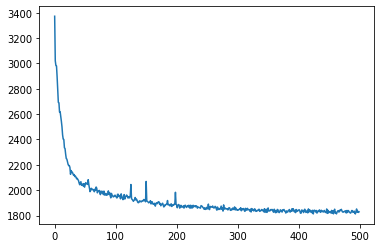

In [9]:
model.fit(train_ds, valid_ds, max_epochs=500, batch_size=batch_size , use_tensorboard=False,
          train_truth=train_ds, valid_truth=valid_ds)

## Load checkpoint with lowest validation error 

torch.Size([66, 60, 49])


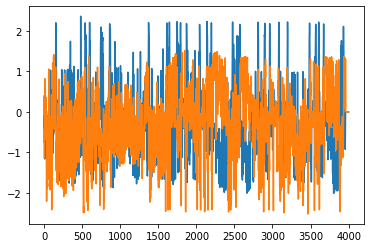

In [10]:
print(output_valid.shape)
#model.plot_factors()
tt = np.zeros(((all_time-start_time),2))
sp = np.zeros(((all_time-start_time),neuron_num))
batch_size=1
gg = int(NRep/batch_size)
import math
def mutual_info(m):
    K=30
    h_y_xw = np.zeros(neuron_num)
    h_y_x = np.zeros(neuron_num)
    T = m.shape[0]
    for n in range(neuron_num):
        for k in range(K):
            h_y_xw_tem = 0
            h_y_x_tem = 0
            for t in range(T):
                h_y_xw_tem += m[t][n]**(k)*np.exp(-m[t][n])/(math.factorial(k)) * np.log(m[t][n]**(k)*np.exp(-m[t][n])/(math.factorial(k)))
                h_y_x_tem += m[t][n]**(k)*np.exp(-m[t][n])/(math.factorial(k))
            h_y_xw[n] += h_y_xw_tem/T
            h_y_x[n] -= h_y_x_tem/T * math.log(h_y_x_tem/T)
            
    return  h_y_xw.sum(), h_y_x.sum()

for k in range(gg):
    t = model.infer_factors(output_valid[batch_size *k:batch_size *(k+1),:])
    spi = model.reconstruct(output_valid[batch_size *k:batch_size *(k+1),:])
    #print(spi.shape)
    for i in range(batch_size):
        for j in range(Time):
            tt[(i+batch_size*k)*Time+j,:] = t[i][j].to('cpu').detach().numpy().copy()
            #print(model.mcdropout(output_valid[batch_size *k:batch_size *(k+1),:],np.ones(2),T=10))
            #y_hat = model.mcdropout(output_valid[batch_size *k:batch_size *(k+1),:],np.ones(2),T=10)
            #print(mutual_info(y_hat))
            #obs_mc_mean = y_hat.mean(axis=0)
            #obs_mc_std = y_hat.std(axis=0)
            #print(poisson_entropy(np.round(obs_mc_mean)))
            for l in range(neuron_num):
                sp[(i+batch_size*k)*Time+j,l] = spi[j][l]
plt.figure()
plt.plot(tt)

In [11]:
#next_state = model.transition_rnn(tt[:1,:])
#print(next_state)

## Plot results summary 

In [12]:
"""for i in range(neuron_num):
    plt.figure()
    plt.plot(y_data[:,i], linewidth = 2)
    plt.plot(sp[:,i],'r',linewidth = 1)
    plt.title(i)
    plt.ylim(-2,20)"""

"for i in range(neuron_num):\n    plt.figure()\n    plt.plot(y_data[:,i], linewidth = 2)\n    plt.plot(sp[:,i],'r',linewidth = 1)\n    plt.title(i)\n    plt.ylim(-2,20)"

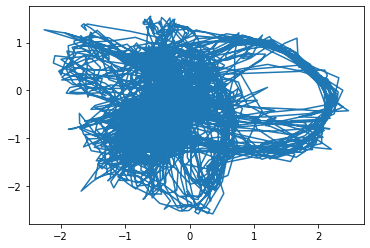

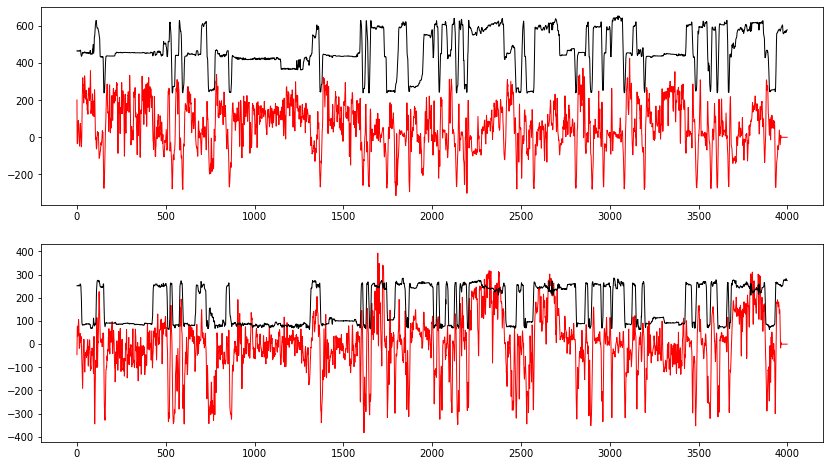

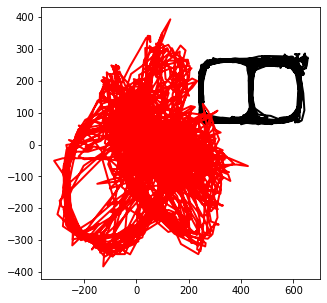

In [13]:
import funs
from scipy import signal
qz_mean_est = tt
#plt.plot(qz_mean_est[:,1])
qz_est_norm = qz_mean_est#np.stack(qz_mean_est)/np.linalg.norm(np.stack(qz_mean_est))
qz_est_norm[:,0] = signal.savgol_filter(qz_est_norm[:,0], 11, 5)
qz_est_norm[:,1] = signal.savgol_filter(qz_est_norm[:,1],11, 5)
plt.plot(qz_est_norm[:,0],qz_est_norm[:,1])
z_true_c = traj# - x_test.mean(axis=0)
z_true_norm = z_true_c#/np.linalg.norm(z_true_c)

R = funs.compute_optimal_rotation(np.stack(qz_est_norm), z_true_norm, scale=True)
qz_est_norm_R = np.stack(qz_est_norm).dot(R)

#qz_est_norm_R[:,0] = signal.savgol_filter(qz_est_norm_R[:,0], 21, 5)
#qz_est_norm_R[:,1] = signal.savgol_filter(qz_est_norm_R[:,1],21, 5)
st=0
en=4000
plt.figure(figsize=(14,8))
plt.subplot(211)
plt_post = plt.plot(qz_est_norm_R[st:en,0],'r', linewidth = 1, label = 'posterior mean')
plt_true = plt.plot(z_true_norm[st:en,0], 'k', linewidth = 1, label = '\"true\" mean')
plt.subplot(212)
plt_post = plt.plot(qz_est_norm_R[st:en,1],'r', linewidth = 1, label = 'posterior mean')
plt_true = plt.plot(z_true_norm[st:en,1], 'k', linewidth = 1, label = '\"true\" mean')

fig = plt.figure(figsize=(5,5))
plt.plot(z_true_norm[st:en,0], z_true_norm[st:en,1], lw=2, color = 'k')
plt.plot(qz_est_norm_R[st:en,0], qz_est_norm_R[st:en,1], lw=2, color = 'r')

In [14]:
#np.savetxt('lfads_k09_01170748.csv', qz_est_norm, delimiter=',')

<IPython.core.display.Javascript object>


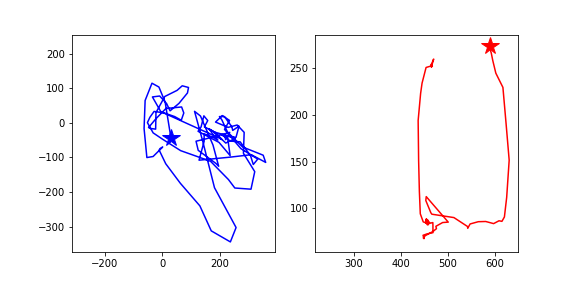

In [16]:
%matplotlib nbagg

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

#fig = plt.figure()
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(8, 4))
ims = []
for i in range(1000):
    x_list = []
    y_list = []
    x_list2 = []
    y_list2 = []
    for j in range(i):
        x = qz_est_norm_R[j,0]
        y = qz_est_norm_R[j,1]
        x2 = z_true_norm[j,0]
        y2 = z_true_norm[j,1]
        x_list.append(x)
        y_list.append(y)
        x_list2.append(x2)
        y_list2.append(y2)
    #print(len(x_list))
    im = ax1.plot(x_list,y_list,color='b',ls='solid', 
         marker='*',ms=18,markevery=slice(i-1,i,1))
    im2 = ax2.plot(x_list2,y_list2,color='r',ls='solid', 
         marker='*',ms=18,markevery=slice(i-1,i,1))
    ims.append(im+im2)

ani = animation.ArtistAnimation(fig,ims,interval=50)
plt.show()